# Joint maximum a posteriori estimate

In [1]:
using CMBLensing
using PyPlot

┌ Info: Precompiling CMBLensing [b60c06c0-7e54-11e8-3788-4bd722d65317]
└ @ Base loading.jl:1242
┌ Warning: Package CMBLensing does not have Setfield in its dependencies:
│ - If you have CMBLensing checked out for development and have
│   added Setfield as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CMBLensing
└ Loading Setfield into CMBLensing from project dependency, future warnings for CMBLensing are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



## Compute spectra

First, compute the fiducial CMB power spectra which generate our simulated data,

In [2]:
Cℓ = camb(r=0.05);

Next, chose the noise power-spectra we are assuming,

In [3]:
Cℓn = noisecls(1, ℓknee=100);

Plot these up for reference,

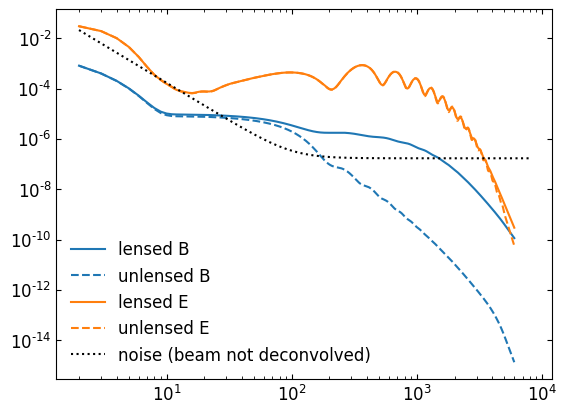

In [4]:
loglog(Cℓ[:f̃][:BB],c="C0")
loglog(Cℓ[:f][:BB],"--",c="C0")
loglog(Cℓ[:f̃][:EE],c="C1")
loglog(Cℓ[:f][:EE],"--",c="C1")
loglog(Cℓn[:BB],"k:")
legend(["lensed B","unlensed B","lensed E","unlensed E", "noise (beam not deconvolved)"]);

## Configure the type of data

These describe the setup of the simulated data we are going to work with (and can be changed),

In [5]:
Θpix  = 3        # pixel size in arcmin
Nside = 128      # number of pixels per side in the map
use   = :P       # type of data to use (can be :T, :P, or :TP)
T     = Float32  # data type (Float32 is ~2 as fast as Float64);

## Generate simulated data

With these defined, the following generates the simulated data and returns the true unlensed and lensed CMB fields, `f` and `f̃` ,and the true lensing potential, `ϕ`, as well as a number of other quantities stored in the "DataSet" object `ds`. 

In [6]:
@unpack f, f̃, ϕ, ds = load_sim_dataset(
    seed = 3,
    Cℓ = Cℓ,
    Cℓn = Cℓn,
    θpix = Θpix,
    T = T,
    Nside = Nside,
    use = use,
)

@unpack Cf, Cϕ = ds;

## Examine simulated data

The true $\phi$ map,

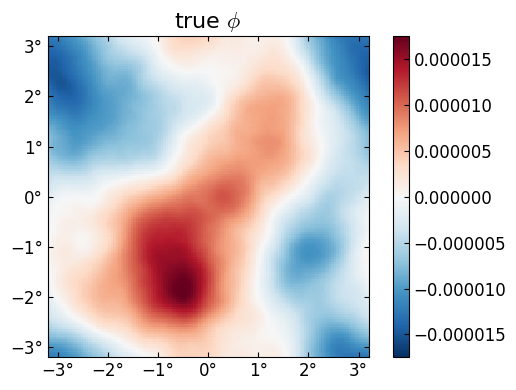

In [7]:
plot(ϕ, title = raw"true $\phi$");

The "true" unlensed field, $f$,

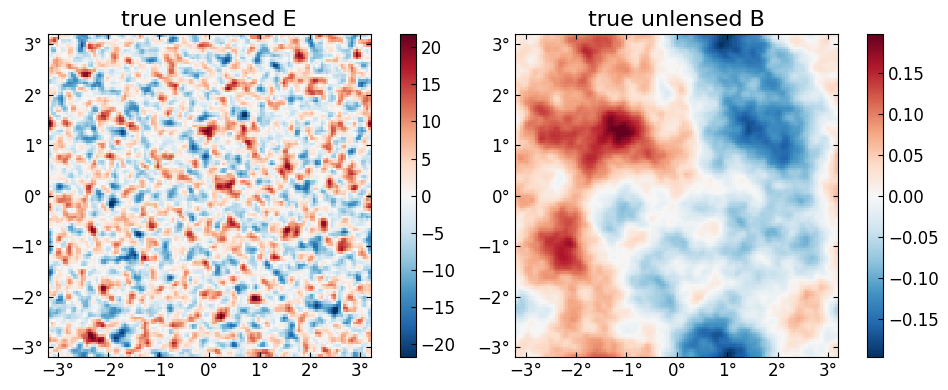

In [8]:
plot(f, title = "true unlensed " .* ["E" "B"]);

And the "true" lensed field,

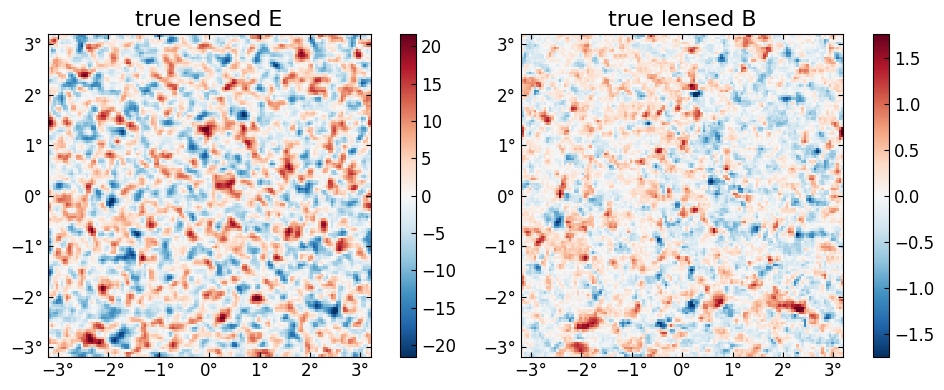

In [9]:
plot(LenseFlow(ϕ)*f, title = "true lensed " .* ["E" "B"]);

The data (stored in the `ds` object) is basically `f̃` with a beam applied plus a sample of the noise,

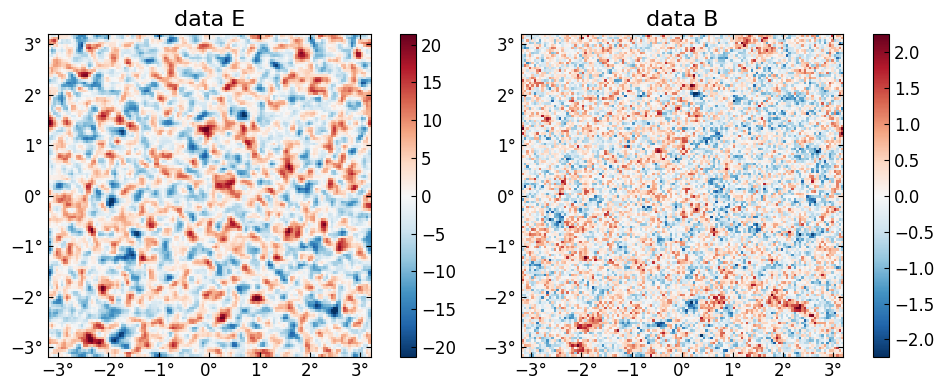

In [10]:
plot(ds.d, title = "data " .* ["E" "B"]);

# Run the minimizer

Now we compute the maximum of the joint posterior, $\mathcal{P}\big(f, \phi \,\big|\,d\big)$

In [11]:
@time fbf, ϕbf, tr = MAP_joint(ds, nsteps=30, progress=:verbose, αmax=0.3);

(step=1, χ²=43095.78, Ncg=5)
(step=2, χ²=37498.30, Ncg=7, α=0.015109)
(step=3, χ²=35814.16, Ncg=6, α=0.021678)
(step=4, χ²=35104.89, Ncg=6, α=0.015126)
(step=5, χ²=34614.47, Ncg=6, α=0.023681)
(step=6, χ²=34313.39, Ncg=6, α=0.014259)
(step=7, χ²=34055.08, Ncg=6, α=0.026641)
(step=8, χ²=33880.53, Ncg=6, α=0.012995)
(step=9, χ²=33706.83, Ncg=6, α=0.032235)
(step=10, χ²=33588.29, Ncg=6, α=0.011610)
(step=11, χ²=33441.90, Ncg=6, α=0.046751)
(step=12, χ²=33346.99, Ncg=6, α=0.010170)
(step=13, χ²=33167.36, Ncg=6, α=0.102652)
(step=14, χ²=33073.17, Ncg=6, α=0.008815)
(step=15, χ²=32881.18, Ncg=6, α=0.241844)
(step=16, χ²=32815.46, Ncg=5, α=0.008552)
(step=17, χ²=32802.16, Ncg=5, α=0.046773)
(step=18, χ²=32792.16, Ncg=4, α=0.010362)
(step=19, χ²=32766.15, Ncg=5, α=0.126376)
(step=20, χ²=32749.73, Ncg=5, α=0.009135)
(step=21, χ²=32707.56, Ncg=4, α=0.299424)
(step=22, χ²=32696.19, Ncg=4, α=0.011517)
(step=23, χ²=32694.19, Ncg=3, α=0.023547)
(step=24, χ²=32692.72, Ncg=3, α=0.019082)
(step=25, χ²=

# Examine results

The expected value of the final best-fit $\chi^2 (=-2\log \mathcal{P}$) is given by the number degrees of freedom in the data, i.e. the total number of pixels in T and/or EB.

In [12]:
χ² = -2tr[end][:lnPcur]

32685.76359250259

In [13]:
dof = getproperty((T=1, P=2, TP=3),use) * Nside^2

32768

Here's how far away our final $\chi^2$ is from this expectation, in units of $\sigma$. We expect this should be somewhere in the range (-3,3) for about 99.7% of simulated datasets.

In [14]:
(χ² - dof)/sqrt(2dof)

-0.3212359667867588

Here's the best-fit $\phi$ relative to the truth,

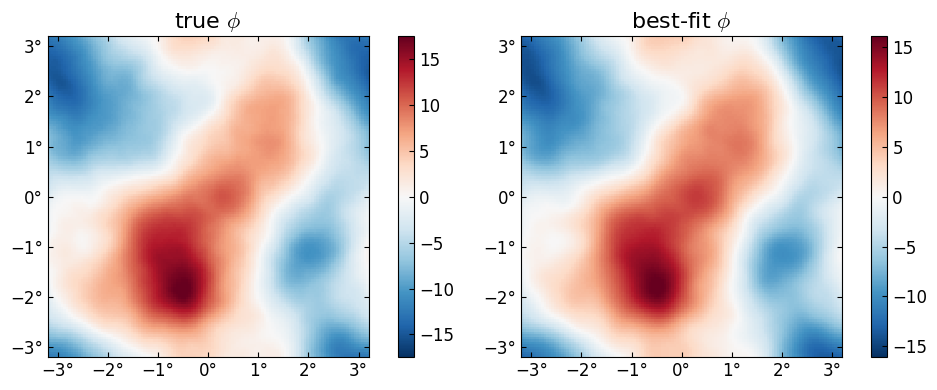

In [15]:
plot(10^6*[ϕ ϕbf], title=["true" "best-fit"] .* raw" $\phi$");

Here is the difference in terms of the power spectra. Note the best-fit has high-$\ell$ power suppressed, like a Wiener filter solution (in fact what we're doing here is akin to a non-linear Wiener filter). In the high S/N region ($\ell\lesssim1000$), the difference is approixmately equal to the noise, which you can see is almost two orders of magnitude below the signal.

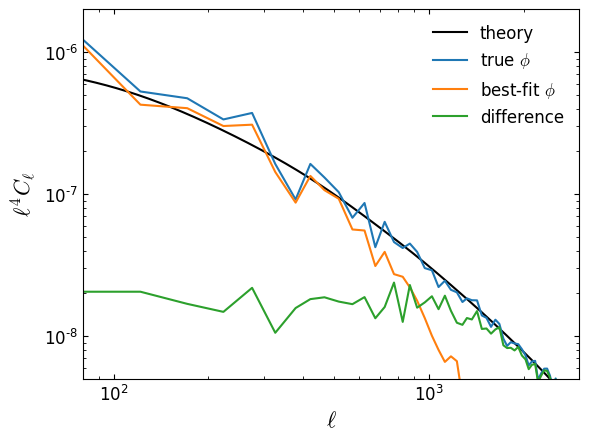

In [16]:
loglog(ℓ⁴ * Cℓ[:f][:ϕϕ], "k")
loglog(ℓ⁴ * get_Cℓ(ϕ))
loglog(ℓ⁴ * get_Cℓ(ϕbf))
loglog(ℓ⁴ * get_Cℓ(ϕbf-ϕ))
xlim(80,3000)
ylim(5e-9,2e-6)
legend(["theory",raw"true $\phi$", raw"best-fit $\phi$", "difference"])
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$");

The best-fit unlensed fields relative to truth,

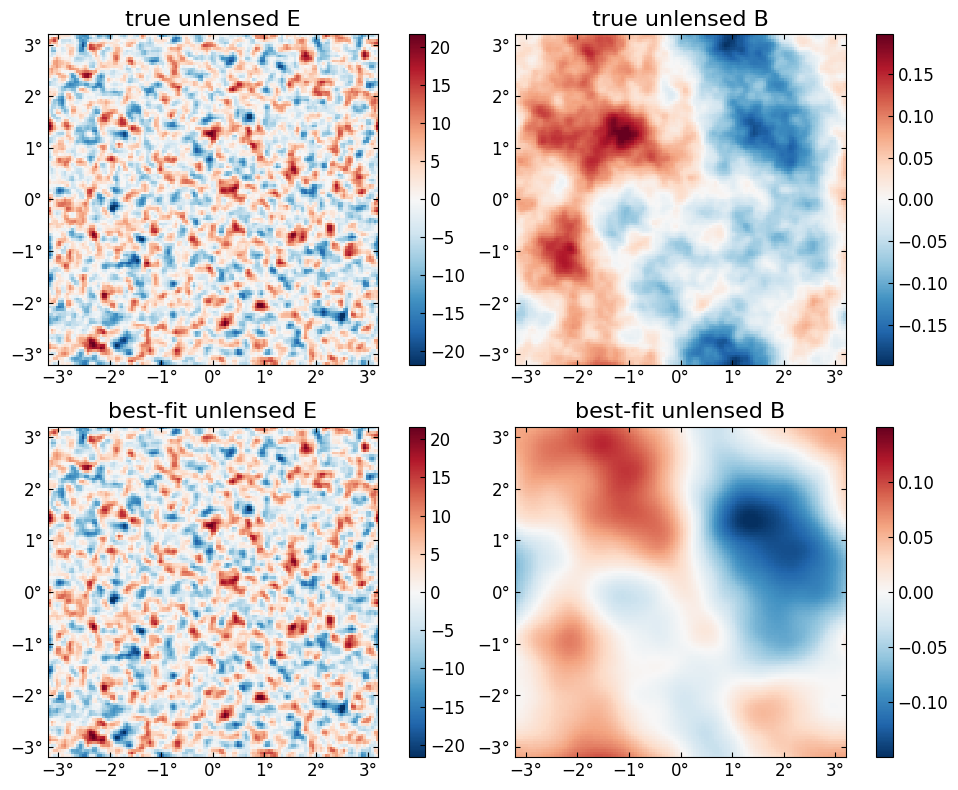

In [17]:
plot([f,fbf], title = ["true", "best-fit"] .* " unlensed " .* ["E" "B"]);

The best-fit lensed field (bottom row) relative to truth (top row),

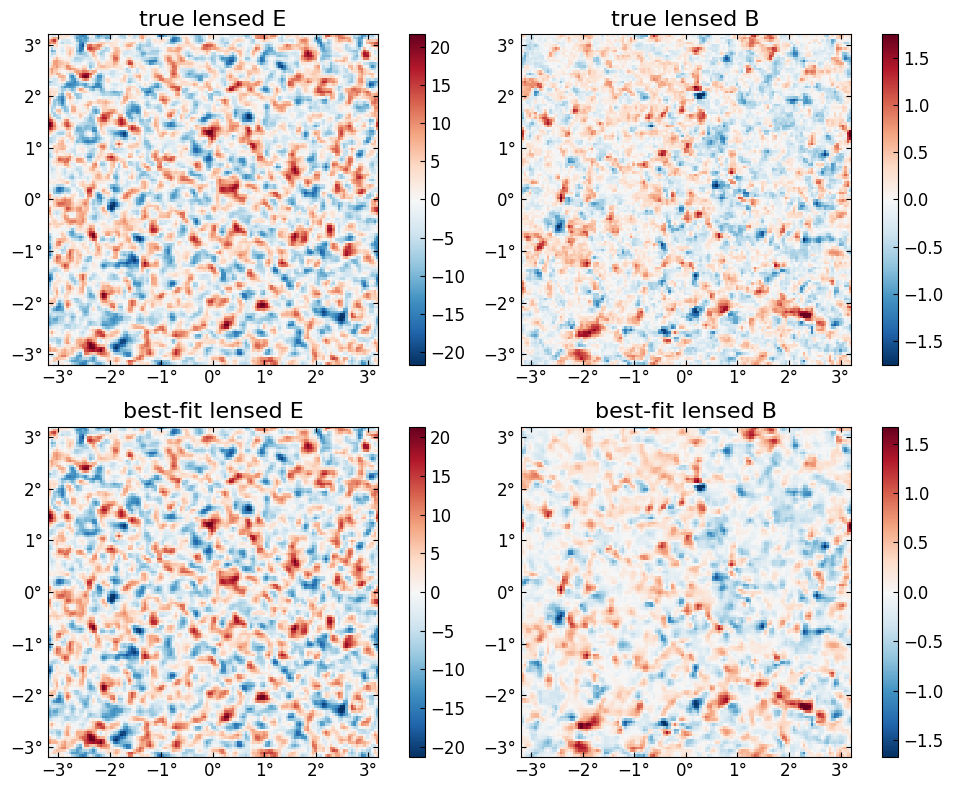

In [18]:
plot([f̃, LenseFlow(ϕbf)*fbf], title = ["true", "best-fit"] .* " lensed " .* ["E" "B"]);